# Masse

In [ ]:
import pyRootPwa
import os

import numpy as np
#import scipy.stats
import scipy
import matplotlib.pyplot as plt
import math
import mle

In [ ]:
dir = '/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/TEST_FOLDER_RUNS'
nmbFolder = len([name for name in os.listdir(dir)])

allIntegralMatrixes = np.empty(nmbFolder, dtype=pyRootPwa.libRootPwaPy.ampIntegralMatrix)

for i in range(0,nmbFolder):
    psIntegralPath = dir + '/ROOTPWA_MC_TEST' + str(i) + '/ints/integral_binID-0_2.root'
    intFile = pyRootPwa.ROOT.TFile.Open(psIntegralPath, "READ")
    intMeta = pyRootPwa.core.ampIntegralMatrixMetadata.readIntegralFile(intFile)
    allIntegralMatrixes[i] = intMeta.getAmpIntegralMatrix() 

    
    
nmbWaves = allIntegralMatrixes[0].nmbWaves()
vecMatrix = np.empty((nmbWaves, nmbWaves), dtype=np.ndarray)
for waveIndexI in range(0,nmbWaves):
    for waveIndexJ in range(0,nmbWaves): #waveIndexI+1):
         vecMatrix[waveIndexI][waveIndexJ] = np.empty(nmbFolder, dtype=complex) 

for i in range(0,nmbFolder):
    for waveIndexI in range(0,nmbWaves):
        for waveIndexJ in range(0,nmbWaves): #waveIndexI+1):
            vecMatrix[waveIndexI][waveIndexJ][i] = allIntegralMatrixes[i].element(waveIndexI, waveIndexJ)

In [ ]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - 0.5 * ((x - mean) / standard_deviation) ** 2)
def chiSquared(n, bins, f, popt):
    f_exp = []
    for i in range(0,len(n)):
        f_exp.append(f(bins[i], *popt))
        #print i, n[i],  f_exp[i]
    c , p = scipy.stats.chisquare(np.array(n, dtype=np.float32), np.array(f_exp, dtype=np.float32))
    return c, p
# https://github.com/ibab/python-mle
def calcMLE(xs, ys, meanEstimated, amplitudeEstimated, standardDeviationEstimated):
    
    # Define model
    xMLE = mle.var('xMLE', observed=True, vector=True)
    yMLE = mle.var('yMLE', observed=True, vector=True)
    
    mean = mle.var('mean')
    amplitude = mle.var('amplitude')
    standardDeviation = mle.var('standardDeviation')
    sigma = mle.var('sigma')
    
    model = mle.Normal(yMLE,gaussian(xMLE, mean, amplitude, standardDeviation), sigma)

    # Fit model to data
    result = model.fit({'xMLE': xs, 'yMLE': ys}, {'mean': meanEstimated, 'amplitude':amplitudeEstimated, 'standardDeviation': standardDeviationEstimated, 'sigma': 1}, dispMsg=False)
    return result

In [ ]:
def createPlot(matrix, xlabel, nmbFolder, plt, plot = False, waveIndexI = 0, waveIndexJ = 0, errorMsg = ""):
    chiSquaredGauss = (1,1)
    chiSquaredMLE = (1,1)
    popt = (float("nan"), float("nan"), float("nan"))
    nbins = int(math.sqrt(nmbFolder)) * 2
    n, bins = np.histogram(matrix, bins=nbins) # n = number of events per bin
    mean = np.mean(matrix)
    standardDeviation = np.std(matrix)
    var = np.var(matrix)
    amplitude = np.max(n)
    
    #print(' Calc Values (np):  [mean, amp, standardDeviation] = %.8f, %.8f, %.8f' % (mean, amplitude, standardDeviation))

    
    # Generate data from bins as a set of points 
    bin_size = abs(bins[1]-bins[0])
    x = np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0, num=nbins,endpoint=True)
    y = n
    y[y==0]= 1e-8
    x_fit = np.linspace(x[0], x[-1], nbins)

    # Gaussian
    try:
        p0 = scipy.array([mean, amplitude, standardDeviation])
        popt, pcov = scipy.optimize.curve_fit(gaussian,x,y,p0) 
        #print(' Curve fit (Gauss): [mean, amp, standardDeviation] = %.8f, %.8f, %.8f' %(popt[0], popt[1], popt[2]))
        chiSquaredGauss = chiSquared(n, bins, gaussian, popt)
        #print ' Chi-Squared (Gauss):', chiSquaredGauss
        
        if plot:
            y_gauss = gaussian(x_fit, *popt)
            plt.plot(x_fit, y_gauss,linestyle='--',linewidth=2, color='red',label='Gaussian')
    except:
        print 'Error to calc Gaussian'
        errorMsg = "%s\n%i, %i: Error to calc Gaussian" %(errorMsg, waveIndexI, waveIndexJ)

    
    # Maximum Likelyhood Estimate
    try:
        poptMLE = calcMLE(x, y, mean, amplitude, standardDeviation)
        #print(' Curve fit (MLE):   [mean, amp, standardDeviation] = %.8f, %.8f, %.8f' % (poptMLE.x['mean'], poptMLE.x['amplitude'], poptMLE.x['standardDeviation']))
        #print poptMLE.x['standardDeviation']
        chiSquaredMLE = chiSquared(n, bins, gaussian, popt)
        #print ' Chi-Squared (MLE):', chiSquaredMLE
        '''
        if poptMLE['success'] == False:
            print "Error to calc MLE -1-"
            raise ValueError("Error to calc MLE -1-")
        '''
        # Plot the fit
        if plot:
            yMLE = gaussian(x_fit,poptMLE.x['mean'], poptMLE.x['amplitude'], math.fabs(poptMLE.x['standardDeviation']))
            plt.plot(x_fit, yMLE,linestyle=':',linewidth=2, color='black',label='MLE')
    except:
        print 'Error to calc MLE'
        errorMsg = "%s\n%i, %i: Error to calc MLE" %(errorMsg, waveIndexI, waveIndexJ)

    
    if plot:
        plt.bar(bins[:-1], n, width = bin_size)

        axes = plt.gca()
        axes.set_ylim([0,max(n)+1])
        plt.xlabel(xlabel)
        plt.ylabel("Number of events")
    return (chiSquaredGauss, chiSquaredMLE, popt, poptMLE, errorMsg)

In [ ]:
nmbWaves = 5 # Remove for last run
resultMatrixes = np.empty([nmbWaves, nmbWaves], dtype=list)
matrixReal = np.empty(nmbFolder, dtype=float)
matrixImag = np.empty(nmbFolder, dtype=float)
problemValues = []
errorMsg = "\n\nERROR:"
plot = False


for waveIndexI in range(0,nmbWaves):  
    for waveIndexJ in range(0,nmbWaves): #,waveIndexI+1):
        #print waveIndexI, waveIndexJ
        resultVec={'real': {'chiSquaredGauss': '', 'chiSquaredMLE': '', 'popt': '', 'poptMLE': ''}, 'imag': {'chiSquaredGauss': '', 'chiSquaredMLE': '', 'popt': '', 'poptMLE': ''}}
    
        element = vecMatrix[waveIndexI][waveIndexJ]
        for i in range(0,nmbFolder):
            matrixReal[i] = element[i].real
            matrixImag[i] = element[i].imag

        if plot:
            plt.figure(1)
            plt.subplots_adjust(right=2)
            plt.subplot(121)
        result = createPlot(matrixReal, "Real", nmbFolder, plt, plot, waveIndexI, waveIndexJ, errorMsg)
        resultVec['real'] = {'chiSquaredGauss': result[0], 'chiSquaredMLE': result[1], 'popt': result[2], 'poptMLE': result[3]}
        errorMsg = result[4]
        if result[0][1] >= 1 or result[1][1] >= 1 or math.isnan(result[0][1]) or math.isnan(result[1][1]):
            problemValues.append({'waveIndexI': waveIndexI, 'waveIndexJ': waveIndexJ, 'type':'real', 'chiSquaredGauss': result[0], 'chiSquaredMLE': result[1], 'popt': result[2], 'poptMLE': result[3]})
            errorMsg = "%s\n%i, %i: Error to calc real Value" %(errorMsg, waveIndexI, waveIndexJ)
            
            
        if waveIndexI != waveIndexJ:
            print ""
            if plot:
                plt.subplot(122)
            result = createPlot(matrixImag, "Imaginar", nmbFolder, plt ,plot, waveIndexI, waveIndexJ, errorMsg)
            resultVec['imag'] = {'chiSquaredGauss': result[0], 'chiSquaredMLE': result[1], 'popt': result[2], 'poptMLE': result[3]}
            errorMsg = result[4]
            if result[0][1] >= 1 or result[1][1] >= 1 or math.isnan(result[0][1]) or math.isnan(result[1][1]):
                problemValues.append({'waveIndexI': waveIndexI, 'waveIndexJ': waveIndexJ, 'type':'real', 'chiSquaredGauss': result[0], 'chiSquaredMLE': result[1], 'popt': result[2], 'poptMLE': result[3]})
                errorMsg = "%s\n%i, %i: Error to calc imag Value" %(errorMsg, waveIndexI, waveIndexJ)
                
        resultMatrixes[waveIndexI][waveIndexJ] = resultVec
        if plot:
            plt.show()

# Alternative Berechnung

In [ ]:
import uproot
import numpy as np
import os
import math

In [ ]:
def prepareArray(origArray):
    preparedArray = np.zeros(len(origArray), dtype=complex)
    for i in range(0, len(origArray)):
        preparedArray[i] = origArray[i][0]
    return preparedArray

In [ ]:
#ampPath = "/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/TEST_FOLDER/ROOTPWA_MC_TEST0/amps/"
ampPath = "/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/ROOTPWA_MC_TEST_500/amps/"
ampPath = "/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/TEST_FOLDER_RUNS/ROOTPWA_MC_TEST0/amps/"


onlyfiles = []
for filename in sorted(os.listdir(ampPath)):
    onlyfiles.append(filename)
nmbWaves = len(onlyfiles)
ampFile1 = uproot.open(ampPath + onlyfiles[0])
nmbEvents = len(ampFile1[ampFile1.keys()[0]]['amplitude'].get('_incohSubAmps._real').array())
amp = np.zeros((nmbWaves, nmbWaves), dtype = complex)
sd = np.zeros((nmbWaves, nmbWaves), dtype = complex)
ampMatrix = np.zeros((nmbWaves,nmbEvents), dtype = complex)
errorMatrixAlternativ = np.zeros((nmbWaves,nmbEvents), dtype = complex)



for waveIndexI in range(0, nmbWaves):
    if ampMatrix[waveIndexI].all() == 0:
        ampFile1 = uproot.open(ampPath + onlyfiles[waveIndexI])
        key1 = ampFile1.keys()[0]

        incohSubAmpsReal1 = ampFile1[key1]['amplitude'].get('_incohSubAmps._real').array()
        incohSubAmpsImag1 = ampFile1[key1]['amplitude'].get('_incohSubAmps._imag').array()
        ampMatrix[waveIndexI] = prepareArray(np.array(incohSubAmpsReal1 + 1j * incohSubAmpsImag1))
        #print ampMatrix[waveIndexI]
        #raise ValueError('Exit.')


        
    
    for waveIndexJ in range(0, nmbWaves): #waveIndexI + 1): #nmbWaves):
        if ampMatrix[waveIndexJ].all() == 0:
            ampFile2 = uproot.open(ampPath + onlyfiles[waveIndexJ])
            key2 = ampFile2.keys()[0]

            incohSubAmpsReal2 = ampFile2[key2]['amplitude'].get('_incohSubAmps._real').array()
            incohSubAmpsImag2 = ampFile2[key2]['amplitude'].get('_incohSubAmps._imag').array()
            ampMatrix[waveIndexJ] = prepareArray(np.array(incohSubAmpsReal2 + 1j * incohSubAmpsImag2))

        integral = np.sum(ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate())/nmbEvents
        amp[waveIndexI][waveIndexJ] = integral
        amp[waveIndexJ][waveIndexI] = integral     
        
        sdReal = sum(pow((ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate()).real, 2)).real
        sdImag = sum(pow((ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate()).imag, 2)).real
        #print "Var1:", sdReal
        
        
        '''
        sdReal = 0.
        sdImag = 0.
        for subAmp in range(0, len(incohSubAmpsComplex1)):
            sdReal += pow((incohSubAmpsComplex1[subAmp] * incohSubAmpsComplex2.conjugate()[subAmp]).real, 2)
            sdImag += pow((incohSubAmpsComplex1[subAmp] * incohSubAmpsComplex2.conjugate()[subAmp]).imag, 2)
            #print (incohSubAmpsComplex1 * incohSubAmpsComplex2.conjugate()).real[subAmp][0].real, (incohSubAmpsComplex1[subAmp][0] * incohSubAmpsComplex2.conjugate()[subAmp][0]).real
        print "Var2:", sdReal
      '''
    

        sdReal = math.sqrt(sdReal/float(nmbEvents) - pow(amp[waveIndexI][waveIndexJ].real,2))
        sdImag = math.sqrt(sdImag/float(nmbEvents) - pow(amp[waveIndexI][waveIndexJ].imag,2))
        sdComplex = complex(sdReal, sdImag)        
        errorComplex = complex(sdReal/math.sqrt(nmbEvents), sdImag/math.sqrt(nmbEvents))
        errorMatrixAlternativ[waveIndexI][waveIndexJ] = errorComplex
        
        sd[waveIndexI][waveIndexJ] = sdComplex
        sd[waveIndexJ][waveIndexI] = sdComplex 

        #print "%i, %i: %s, %s, %s" %(waveIndexI, waveIndexJ, amp[waveIndexI][waveIndexJ], sd[waveIndexI][waveIndexJ], errorComplex)
        #print "%i, %i: %s, %s" %(waveIndexI, waveIndexJ, amp[waveIndexI][waveIndexJ], errorComplex)
        #print np.cov(amp/nmbEvents)
            #raise ValueError('Exit.')

# --------------------------------------
# Terminal

In [1]:
import csv
import numpy as np

In [2]:
csvData = list(csv.reader(open('ErrorsFromTerminal_50k.csv', 'rb'), delimiter=' '))

In [3]:
nmbWavesPWA = int(csvData[-1][3][:-1]) + 1
errorMatrixPWA = np.zeros((nmbWavesPWA, nmbWavesPWA), dtype = complex)

for k in range(0,len(csvData)/2, 2):
        i = int(csvData[k][3][:-1])
        j = int(csvData[k][4][:-1])
        errorMatrixPWA[i][j] = float(csvData[k][9]) + 1j * float(csvData[k + 1][9])
        errorMatrixPWA[j][i] = float(csvData[k][9]) + 1j * float(csvData[k + 1][9])

In [ ]:
print errorMatrixPWA[1][0]

# Lade Daten

In [4]:
import numpy as np

In [4]:
resultMatrixes = np.load('CompareIntegraleWithVarianzResult_50k.npy')
amp, errorMatrixAlternativ = np.load('AlternativeBerechnung_OhneTest_50k.npy')[0]

# Auswertung

In [5]:
nmbWaves = len(resultMatrixes)
prozentPWAAlternativ = np.zeros((nmbWaves, nmbWaves), dtype = complex)
prozentGaussAlternativ = np.zeros((nmbWaves, nmbWaves), dtype = complex)

for i in range(0,nmbWaves):
    for j in range(0, nmbWaves):
        poptReal = resultMatrixes[i][j]['real']['poptNP'][2]
        #poptReal = resultMatrixes[i][j]['real']['popt'][2]
        #poptReal = resultMatrixes[i][j]['real']['poptMLE']['x']['standardDeviation']
        #integral = resultMatrixes[i][j]['real']['poptMLE']['x']['mean']
        if i == j:
            p1 = errorMatrixPWA[i][j].real
            p2 = poptReal
            p3 = errorMatrixAlternativ[i][j].real
        else:
            poptImag = resultMatrixes[i][j]['imag']['poptNP'][2]
            p1 = errorMatrixPWA[i][j].real + 1j * errorMatrixPWA[i][j].imag
            p2 = poptReal + 1j * poptImag
            p3 = errorMatrixAlternativ[i][j] + 1j * errorMatrixAlternativ[i][j].imag

        #print i, j, p2.real*100/p3.real, p2.real, p3.real
        #print i, j, p1.real*100/p3.real, p2.real, p3.real
        if i == j:
            prozentPWAAlternativ[i][j]   = p1.real*100/p3.real
            prozentGaussAlternativ[i][j] = p2.real*100/p3.real
        else:
            prozentPWAAlternativ[i][j]   = p1.real*100/p3.real + 1j * p1.imag*100/p3.imag
            prozentGaussAlternativ[i][j] = p2.real*100/p3.real + 1j * p2.imag*100/p3.imag
                  

print 'Finish'

Finish


# Graph

In [6]:
import matplotlib.pyplot as plt

In [22]:
nmbWavess = 95

for i in range(0,20):
    for j in range(0, 1):
        if i == j:
            poptReal = resultMatrixes[0][0]['real']['poptNP'][2]
            #poptReal = resultMatrixes[i][j]['real']['popt'][2]
            #poptReal = resultMatrixes[i][j]['real']['poptMLE']['x']['standardDeviation']
            #integral = resultMatrixes[i][j]['real']['poptMLE']['x']['mean']
            
            p1 = errorMatrixPWA[i][j].real
            p2 = poptReal
            p3 = errorMatrixAlternativ[i][j].real
        else:
            poptReal = resultMatrixes[i][j]['real']['poptNP'][2] # resultMatrixes[i][j]['real']['poptMLE']['x']['standardDeviation']
            poptImag = resultMatrixes[i][j]['imag']['popt'][2] # resultMatrixes[i][j]['imag']['poptMLE']['x']['standardDeviation']
            #integral = resultMatrixes[i][j]['real']['poptMLE']['x']['mean'] + 1j * resultMatrixes[i][j]['imag']['poptMLE']['x']['mean']
            p1 = errorMatrixPWA[i][j].real + 1j * errorMatrixPWA[i][j].imag
            p2 = poptReal + 1j * poptImag
            p3 = errorMatrixAlternativ[i][j] + 1j * errorMatrixAlternativ[i][j].imag

        print resultMatrixes[i][j]['real']['popt'][2]
        print i, j, p2.real*100/p3.real, p2.real, p3.real
        print i, j, p1.real*100/p3.real, p1.real, p3.real
        print ""

print 'Finish'

0.0038821758504324817
0 0 99.52667965872806 0.0036628257843918403 0.003680245133216023
0 0 115.65044843305465 0.00425622 0.003680245133216023

0.009848769753808977
1 0 101.28222132371347 0.009052435225251058 0.00893783243193106
1 0 116.380566308655 0.0104019 0.00893783243193106

0.000624531802679709
2 0 100.24315066357619 0.0005852543940321932 0.0005838347958518907
2 0 100.01527900507868 0.000583924 0.0005838347958518907

0.001824071039294142
3 0 100.15824328389094 0.0017645680351069117 0.0017617801363641909
3 0 115.46219406230705 0.00203419 0.0017617801363641909

0.008196478955768327
4 0 111.30537553081581 0.00787602042032504 0.00707604676123167
4 0 100.35872061936334 0.00710143 0.00707604676123167

0.002783795336887885
5 0 100.01343668865049 0.0026588043015087033 0.002658447094249711
5 0 121.94299472846666 0.00324179 0.002658447094249711

0.0006807597630144312
6 0 87.36435960922162 0.0007819725615759081 0.00089507044414181
6 0 100.0002855482724 0.000895073 0.00089507044414181

0.0038

/nfs/mnemosyne/user/ga94kuv/private/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


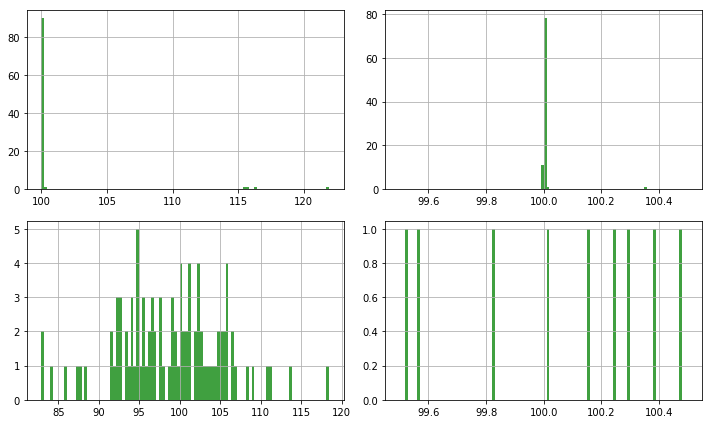

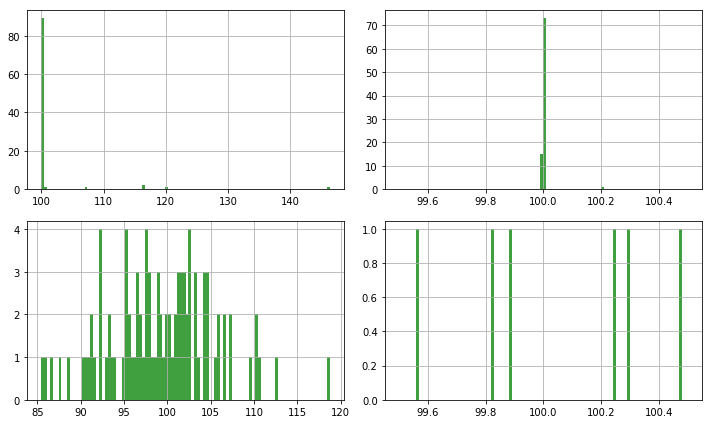

In [7]:
# the histogram of the data
for i in range(0,2): #nmbWaves):


    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
    ax0, ax1, ax2, ax3 = axes.flatten()
    ax0.hist(prozentPWAAlternativ.real[:,i], 100, normed=0, facecolor='green', alpha=0.75)
    ax0.grid(True)
    ax1.hist(prozentPWAAlternativ.real[:,i], 100, normed=0, facecolor='green', alpha=0.75, range=(99.5,100.5))
    ax1.grid(True)
    
    ax2.hist(prozentGaussAlternativ.real[:,i], 100, normed=0, facecolor='green', alpha=0.75)
    ax2.grid(True)
    ax3.hist(prozentGaussAlternativ.real[:,i], 100, normed=0, facecolor='green', alpha=0.75, range=(99.5,100.5))
    ax3.grid(True)
    
    fig.tight_layout()
    plt.show()

    

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
x, y = np.random.rand(2, 100) * 4
#hist, xedges, yedges = np.histogram2d(x, y, bins=4)
hist, xedges, yedges = np.histogram2d(x, y, bins=4)

elements = (len(xedges) - 1) * (len(yedges) - 1)
xpos, ypos = np.meshgrid(xedges[:-1]+0.25, yedges[:-1]+0.25)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)

print xpos

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

dx = dx*0.5
xpos = xpos - dx

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')
ax.bar3d(xpos+dx, ypos, zpos, dx, dy, dz, color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show() 

In [ ]:
delta = 1.1
for i in range(0,1):
    for j in range(0, i+1):
        print resultMatrixes[i][j]['real']['poptMLE']['x']['mean']
        print ""
        print resultMatrixes[i][j]['imag']
        print len(resultMatrixes[i][j]['imag']['poptMLE'])